This notebook demonstrates sample usage of dicompyler-core.

### Load some useful imports:

In [1]:
%matplotlib inline
import os
import numpy as np
from dicompylercore import dicomparser, dvh, dvhcalc
import matplotlib.pyplot as plt
import urllib.request
import os.path

### Download some example data:

In [2]:
%mkdir -p example_data
repo_url = 'https://github.com/dicompyler/dicompyler-core/blob/master/tests/testdata/file?raw=true'
# files = ['ct.0.dcm', 'rtss.dcm', 'rtplan.dcm', 'rtdose.dcm']
files = ['example_data/{}'.format(y) for y in ['rtss.dcm', 'rtdose.dcm']]
file_urls = [repo_url.replace('file', x) for x in files]
# Only download if the data is not present
[urllib.request.urlretrieve(x, y) for x, y in zip(file_urls, files) if not os.path.exists(y)]

[]

### DICOM data can be easily accessed using convenience functions using the `dicompylercore.dicomparser.DicomParser` class:

In [3]:
rtss_dcm = files[0]
rtdose_dcm = files[1]
rtss = dicomparser.DicomParser(rtss_dcm)
rtdose = dicomparser.DicomParser(rtdose_dcm)

### Get a list of structures:

In [4]:
key = 5
structures = rtss.GetStructures()
structures[key]

{'color': array([255, 128,   0]),
 'empty': False,
 'id': 5,
 'name': 'Heart',
 'type': 'ORGAN'}

### Iterate through slices of the dose grid:

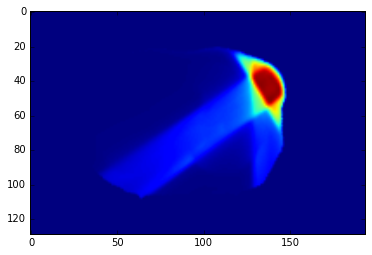

In [5]:
planes = \
    (np.array(rtdose.ds.GridFrameOffsetVector) \
    * rtdose.ds.ImageOrientationPatient[0]) \
    + rtdose.ds.ImagePositionPatient[2]
dd = rtdose.GetDoseData()

from ipywidgets import FloatSlider, interactive
w = FloatSlider(
    value=0.56,
    min=planes[0],
    max=planes[-1],
    step=np.diff(planes)[0],
    description='Slice Position (mm):',
)

def showdose(z):
    plt.imshow(rtdose.GetDoseGrid(z) * dd['dosegridscaling'],
               vmin=0,
               vmax=dd['dosemax'] * dd['dosegridscaling'])

interactive(showdose, z=w)

### Access DVH data using the `dicompylercore.dvh.DVH` class:

In [6]:
heart = rtdose.GetDVHs()[key]
heart.name = structures[key]['name']
heart.describe()

Structure: Heart
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:    437.46 cm3
Max Dose:  3.10 Gy
Min Dose:  0.02 Gy
Mean Dose: 0.64 Gy
D100:      0.00 Gy
D98:       0.03 Gy
D95:       0.03 Gy
D2cc:      2.93 Gy


DVH(cumulative, 311 bins: [0.0:3.1099999999999777] Gy, volume: 100.00000000000048 %, name: 'Heart', rx_dose: 0 Gy)

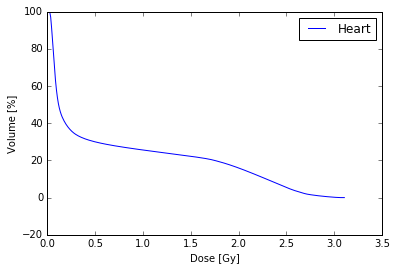

In [7]:
heart.relative_volume.plot()

### Set the Rx dose to show volume statistics and relative dose:

In [8]:
heart.rx_dose = 14
heart.relative_dose().describe()

Structure: Heart
-----
DVH Type:  cumulative, rel dose, abs volume: cm3
Volume:    437.46 cm3
Max Dose:  22.14 %
Min Dose:  0.14 %
Mean Dose: 4.59 %
D100:      0.00 %
D98:       0.21 %
D95:       0.21 %
V100:      0.00 cm3
V95:       0.00 cm3
V5:        121.81 cm3
D2cc:      20.93 %


### Chain functions to view the DVH data in various formats:

In [9]:
tumorbed = rtdose.GetDVHs()[9]
tumorbed.name = structures[9]['name']
tumorbed.rx_dose = 14

DVH(differential, 1458 bins: [0.0:14.579999999999734] Gy, volume: 100.0000000000008 %, name: 'Tumor Bed', rx_dose: 14 Gy)

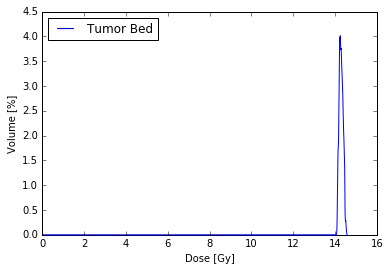

In [10]:
tumorbed.relative_volume.differential.plot()

DVH(cumulative, 1458 bins: [0.0:14.579999999999734] Gy, volume: 12.809180549338702 cm3, name: 'Tumor Bed', rx_dose: 14 Gy)

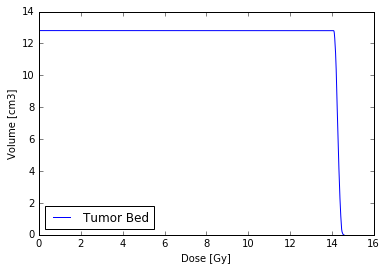

In [11]:
tumorbed.relative_dose().differential.absolute_dose().cumulative.plot()

### Access DVH statistics in multiple ways:

DVH(cumulative, 1274 bins: [0.0:12.739999999999773] Gy, volume: 2008.9485871115003 cm3, name: 'Lt Lung', rx_dose: 14 Gy)

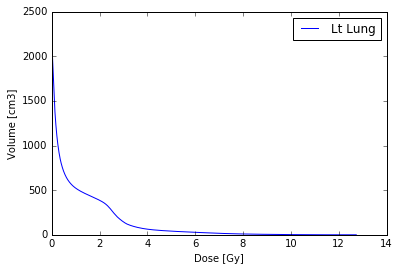

In [12]:
lung = rtdose.GetDVHs()[6]
lung.name = structures[6]['name']
lung.rx_dose = 14
lung.plot()

In [13]:
lung.max

12.729999999999773

In [14]:
lung.V5Gy

dvh.DVHValue(40.830640196588597, 'cm3')

In [15]:
lung.relative_volume.V5Gy

dvh.DVHValue(2.032438284311445, '%')

In [16]:
lung.D2cc

dvh.DVHValue(10.119999999999829, 'Gy')

In [17]:
lung.relative_dose().D2cc

dvh.DVHValue(72.285714285713055, '%')

In [18]:
lung.D1cc == lung.statistic('D1cc') == lung.dose_constraint(1, 'cc')

True

### Plot all DVHs found in a DICOM RT Dose DVH sequence:

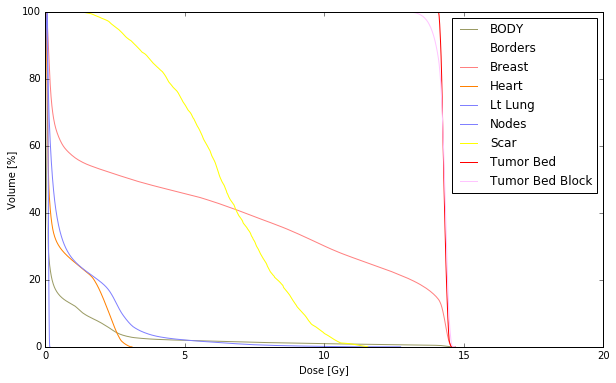

In [19]:
plt.figure(figsize=(10, 6))
plt.axis([0, 20, 0, 100])
for s in structures.values():
    if not s['empty']:
        dvh.DVH.from_dicom_dvh(rtdose.ds, s['id'], name=s['name'], color=s['color']).relative_volume.plot()

### Calculate a DVH from a DICOM RT Structure Set & Dose via the `dicompylercore.dvhcalc.get_dvh` function:

DVH(cumulative, 310 bins: [0.0:3.1000000000000001] Gy, volume: 440.21249999999981 cm3, name: 'Heart', rx_dose: 0 Gy)

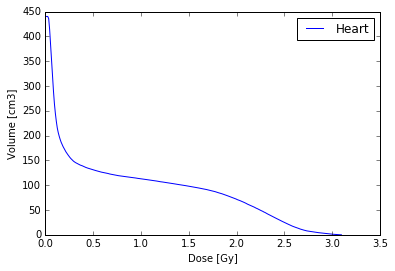

In [20]:
b = dvhcalc.get_dvh(rtss_dcm, rtdose_dcm, key)
b.plot()

In [21]:
def compare_dvh(key=1):
    structure = rtss.GetStructures()[key]
    orig = dvh.DVH.from_dicom_dvh(rtdose.ds, key, name=structure['name'] + ' Orig')
    calc = dvhcalc.get_dvh(rtss_dcm, rtdose_dcm, key)
    calc.name = structure['name'] + ' Calc'
    orig.compare(calc)

Structure:      Heart Orig        Heart Calc          Rel Diff       Abs diff
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:           437.46 cm3        440.21 cm3         +0.63 %          +2.75
Max:                3.10 Gy           3.09 Gy          -0.32 %          -0.01
Min:                0.02 Gy           0.03 Gy         +50.00 %          +0.01
Mean:               0.64 Gy           0.65 Gy          +0.73 %          +0.00
D100:               0.00 Gy           0.00 Gy          +0.00 %          +0.00
D98:                0.03 Gy           0.03 Gy          +0.00 %          +0.00
D95:                0.03 Gy           0.04 Gy         +33.33 %          +0.01
D2cc:               2.93 Gy           2.96 Gy          +1.02 %          +0.03


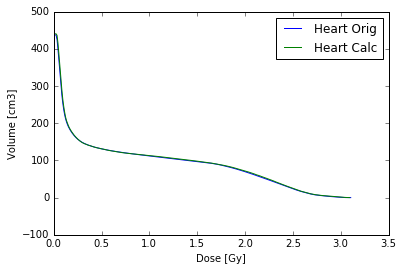

In [22]:
compare_dvh(key)